<a href="https://colab.research.google.com/github/Epicencas/Lab3SL2/blob/main/Lab3SL2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Preparación del Ambiente

In [ ]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import re
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from statsmodels.graphics.tsaplots import plot_acf
import statsmodels.api as sm

### Carga de la Data

In [ ]:
data_path1 = '/content/drive/MyDrive/trainRNN.csv'
dataset = pd.read_csv(data_path1 , parse_dates=['date'])

### Autocorrelación de los Datos

In [ ]:
#autocorrelación
dataset['sales'].autocorr(lag=1)

0.8784369673919291


La autocorrelación es considerablemente alta, por lo que un determinado valor depende de datos anteriores y por lo tanto se puede hacer una predicción.

In [ ]:
fig = plot_acf(dataset['sales'], lags=20, alpha=0.05)
fig.show()

In [ ]:
porcDiff = dataset['sales'].pct_change()
porcDiff = porcDiff.dropna()

In [ ]:
porcDiff.autocorr()

nan

In [ ]:
#selecciono solo la columan date y high
datos_sales = dataset[['date','sales']]
datos_sales.head()

,date,sales
0,2013-01-01,13
1,2013-01-02,11
2,2013-01-03,14
3,2013-01-04,13
4,2013-01-05,10


In [ ]:
#fijo la fecha como indice del data.frame
datos_ts =  datos_sales.set_index('date')
#organizar a partir del indice
datos_ts.sort_index(inplace=True)
#ver el conjunto de datos
datos_ts.head()

,sales
date,
2013-01-01,13
2013-01-01,26
2013-01-01,27
2013-01-01,54
2013-01-01,35


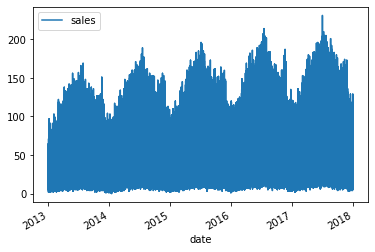

In [ ]:
datos_ts.plot()

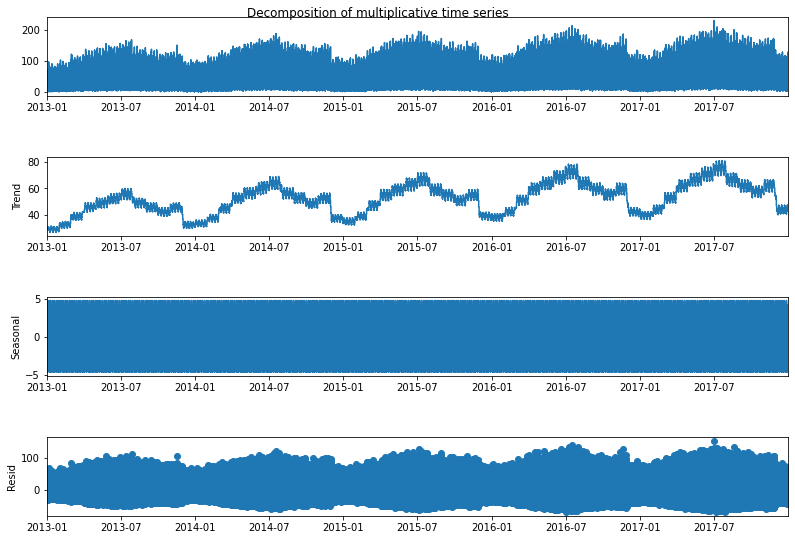

In [ ]:
decomposition = sm.tsa.seasonal_decompose(datos_ts, model='additive', period = int(len(datos_ts)/400))

fig = decomposition.plot()
fig.set_figwidth(12)
fig.set_figheight(8)
fig.suptitle('Decomposition of multiplicative time series')
fig.show()

In [ ]:
datos_ts_m = datos_ts.resample('M').mean()
datos_ts_m.head()

,sales
date,
2013-01-31,29.348645
2013-02-28,32.815500
2013-03-31,39.831097
2013-04-30,45.484933
2013-05-31,49.241419


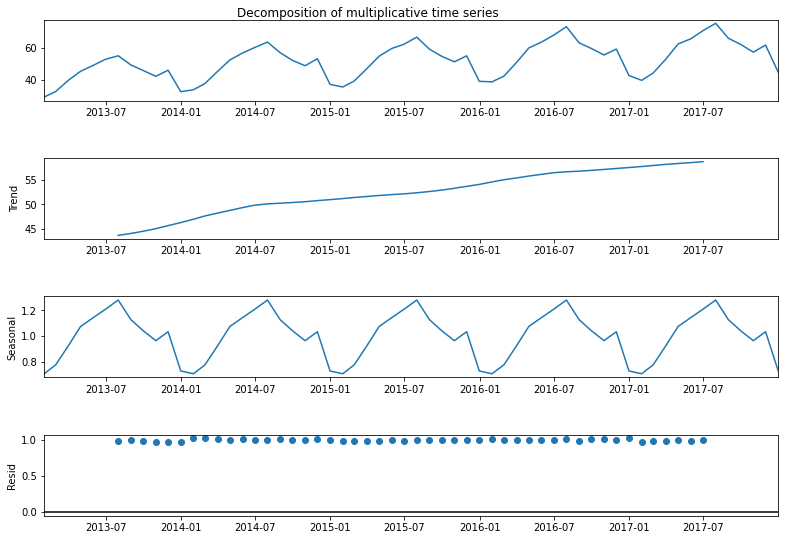

In [ ]:
decomposition = sm.tsa.seasonal_decompose(datos_ts_m, model='multiplicative')

fig = decomposition.plot()
fig.set_figwidth(12)
fig.set_figheight(8)
fig.suptitle('Decomposition of multiplicative time series')
fig.show()

### Data de Entrenamiento (80% del total de la data)

In [ ]:
data_path1 = '/content/drive/MyDrive/trainRNN.csv'
dataset = pd.read_csv(data_path1 )

In [ ]:
datatrain = dataset[dataset['date'].str.contains('2013|2014|2015|2016', regex=True)]
datatrain

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10
...,...,...,...,...
912630,2016-12-27,10,50,60
912631,2016-12-28,10,50,43
912632,2016-12-29,10,50,68
912633,2016-12-30,10,50,63


### Data de Validación (20% del total de la data)

In [ ]:
datatest = dataset[dataset['date'].str.contains('2017')]
datatest

,date,store,item,sales
1461,2017-01-01,1,1,19
1462,2017-01-02,1,1,15
1463,2017-01-03,1,1,10
1464,2017-01-04,1,1,16
1465,2017-01-05,1,1,14
...,...,...,...,...
912995,2017-12-27,10,50,63
912996,2017-12-28,10,50,59
912997,2017-12-29,10,50,74
912998,2017-12-30,10,50,62


In [ ]:
datatrain1 = datatrain.query('item == 30')

In [ ]:
datatrain1 = datatrain1.pivot(index = 'date', columns = 'store', values = 'sales')

In [ ]:
datatrain1['Total_Sales'] = datatrain1.sum(axis = 1)

In [ ]:
#datatrain1.columns
datatrain1 = datatrain1.drop([1, 2, 3,4,5,6,7,8,9,10], axis=1)

In [ ]:
datatrain1 = datatrain1.iloc[:, 0:1].values

In [ ]:
datatrain1

array([[219],
       [202],
       [237],
       ...,
       [313],
       [375],
       [399]])

In [ ]:
#dataTrainT1 = datatrain.query('item == 30')
#dataTrainT1 = dataTrainT1.iloc[:, 3:4].values
#

In [ ]:
#dataTrainT1

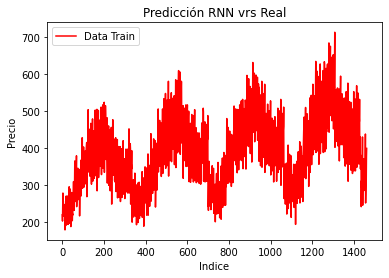

In [ ]:
plt.plot(datatrain1, color='red', label='Data Train')
plt.title('Predicción RNN vrs Real')
plt.xlabel("Indice")
plt.ylabel("Precio")
plt.legend()
plt.show()

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))
datatrain1_scaled = scaler.fit_transform(datatrain1)

In [ ]:
X_train = []
Y_train = []

#secuenciamos los datos.
cantidad = datatrain1_scaled.shape[0]
ventana = 20
for i in range(ventana, cantidad):
  X_train.append(datatrain1_scaled[i - ventana: i, 0])
  Y_train.append(datatrain1_scaled[i, 0])

In [ ]:
X_train = np.array(X_train)
y_train = np.array(Y_train)

In [ ]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1)) #reshape para entrada en Keras.

In [ ]:
forecaster = Sequential()

#capa1
forecaster.add(LSTM(input_shape=(X_train.shape[1], 1), units=50, return_sequences=True))

#capa2
forecaster.add(LSTM(units=50, return_sequences=True))

#capa3
forecaster.add(LSTM(units=25, return_sequences=True))

#capa4 - NOTAAAAR :) que la capa previa a la salida, no requiere feedback ya que es el resultado final.
forecaster.add(LSTM(units=75, return_sequences=False))

#capa de salida
forecaster.add(Dense(units=1, activation='relu'))

In [ ]:
#parametros de optimización
forecaster.compile(optimizer='adam', loss='mean_squared_error')

In [ ]:
#parametros de entrenamiento
forecaster.fit(X_train, y_train, epochs=100, batch_size=32)

Epoch 1/100
46/46 [==============================] - 11s 50ms/step - loss: 0.0356
Epoch 2/100
46/46 [==============================] - 2s 49ms/step - loss: 0.0140
Epoch 3/100
46/46 [==============================] - 2s 49ms/step - loss: 0.0136
Epoch 4/100
46/46 [==============================] - 2s 48ms/step - loss: 0.0146
Epoch 5/100
46/46 [==============================] - 2s 49ms/step - loss: 0.0131
Epoch 6/100
46/46 [==============================] - 2s 49ms/step - loss: 0.0131
Epoch 7/100
46/46 [==============================] - 2s 49ms/step - loss: 0.0136
Epoch 8/100
46/46 [==============================] - 3s 69ms/step - loss: 0.0141
Epoch 9/100
46/46 [==============================] - 4s 81ms/step - loss: 0.0143
Epoch 10/100
46/46 [==============================] - 2s 54ms/step - loss: 0.0140
Epoch 11/100
46/46 [==============================] - 2s 50ms/step - loss: 0.0124
Epoch 12/100
46/46 [==============================] - 2s 49ms/step - loss: 0.0120
Epoch 13/100
46/46 [====

In [ ]:
#forecaster.save('/content/drive/MyDrive/RNN_v1.h5')

In [ ]:
datatest1 = datatest.query('item == 30')

In [ ]:
datatest1 = datatest1.pivot(index = 'date', columns = 'store', values = 'sales')

In [ ]:
datatest1['Total_Sales'] = datatest1.sum(axis = 1)

In [ ]:
datatest1 = datatest1.drop([1, 2, 3,4,5,6,7,8,9,10], axis=1)

In [ ]:
datatest1 = datatest1.iloc[:, 0:1].values

In [ ]:
datatest1

array([[392],
       [241],
       [294],
       [286],
       [329],
       [304],
       [346],
       [389],
       [266],
       [295],
       [297],
       [265],
       [329],
       [348],
       [394],
       [247],
       [261],
       [305],
       [276],
       [311],
       [345],
       [344],
       [248],
       [255],
       [291],
       [258],
       [325],
       [335],
       [369],
       [221],
       [283],
       [299],
       [340],
       [351],
       [421],
       [382],
       [261],
       [323],
       [299],
       [308],
       [364],
       [380],
       [429],
       [274],
       [333],
       [326],
       [357],
       [368],
       [383],
       [418],
       [259],
       [321],
       [305],
       [354],
       [382],
       [413],
       [423],
       [257],
       [305],
       [360],
       [365],
       [439],
       [464],
       [515],
       [352],
       [382],
       [360],
       [349],
       [440],
       [433],
       [510],
      

In [ ]:
#datatest = datatest.query('item == 30')
real_test_price = datatest1
#real_test_price

In [ ]:
real_test_price

array([[392],
       [241],
       [294],
       [286],
       [329],
       [304],
       [346],
       [389],
       [266],
       [295],
       [297],
       [265],
       [329],
       [348],
       [394],
       [247],
       [261],
       [305],
       [276],
       [311],
       [345],
       [344],
       [248],
       [255],
       [291],
       [258],
       [325],
       [335],
       [369],
       [221],
       [283],
       [299],
       [340],
       [351],
       [421],
       [382],
       [261],
       [323],
       [299],
       [308],
       [364],
       [380],
       [429],
       [274],
       [333],
       [326],
       [357],
       [368],
       [383],
       [418],
       [259],
       [321],
       [305],
       [354],
       [382],
       [413],
       [423],
       [257],
       [305],
       [360],
       [365],
       [439],
       [464],
       [515],
       [352],
       [382],
       [360],
       [349],
       [440],
       [433],
       [510],
      

In [ ]:
#datatrain = datatrain.query('store == 9 & item == 30')
#datatrain = datatest.iloc[:, 1:2].values
#datatest = datatest.query('store == 9 & item == 30')
#datatest = datatest.iloc[:, 1:2].values

In [ ]:
pd.Series(datatrain1[:,0])

0       219
1       202
2       237
3       278
4       255
       ... 
1456    277
1457    310
1458    313
1459    375
1460    399
Length: 1461, dtype: int64

In [ ]:
dataset_total = pd.concat((pd.Series(datatrain1[:,0]), pd.Series(datatest1[:,0])), axis=0)
dataset_total

0      219
1      202
2      237
3      278
4      255
      ... 
360    313
361    330
362    345
363    391
364    394
Length: 1826, dtype: int64

In [ ]:
input_test = dataset_total[len(dataset_total) - len(datatest1) - ventana : ].values
input_test = input_test.reshape(-1, 1)
input_test = scaler.transform(input_test)
input_test

array([[0.125     ],
       [0.24813433],
       [0.20895522],
       [0.29104478],
       [0.32835821],
       [0.32835821],
       [0.36007463],
       [0.19962687],
       [0.25746269],
       [0.25746269],
       [0.31529851],
       [0.28358209],
       [0.35261194],
       [0.48507463],
       [0.13619403],
       [0.18470149],
       [0.24626866],
       [0.25186567],
       [0.36753731],
       [0.41231343],
       [0.39925373],
       [0.11753731],
       [0.21641791],
       [0.20149254],
       [0.28171642],
       [0.23507463],
       [0.31343284],
       [0.39365672],
       [0.1641791 ],
       [0.21828358],
       [0.22201493],
       [0.16231343],
       [0.28171642],
       [0.31716418],
       [0.40298507],
       [0.12873134],
       [0.15485075],
       [0.2369403 ],
       [0.18283582],
       [0.24813433],
       [0.31156716],
       [0.30970149],
       [0.13059701],
       [0.14365672],
       [0.2108209 ],
       [0.14925373],
       [0.27425373],
       [0.292

In [ ]:
cantidad_final = len(input_test)
cantidad_final

385

In [ ]:
X_test = []
for i in range(ventana, cantidad_final):
  X_test.append(input_test[i - ventana:i, 0])

X_test = np.array(X_test)

In [ ]:
X_test.shape

(365, 20)

In [ ]:
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [ ]:
X_test.shape

(365, 20, 1)

In [ ]:
predicciones_rnn = forecaster.predict(X_test)
predicciones_rnn

array([[0.3560475 ],
       [0.13651429],
       [0.24186179],
       [0.25427613],
       [0.27594805],
       [0.3026887 ],
       [0.36136675],
       [0.36114532],
       [0.10522185],
       [0.19260584],
       [0.20309934],
       [0.24374121],
       [0.28074715],
       [0.32205546],
       [0.37035602],
       [0.11115392],
       [0.20502685],
       [0.19525963],
       [0.2331618 ],
       [0.2582229 ],
       [0.29246804],
       [0.33999035],
       [0.12111381],
       [0.16536549],
       [0.17143829],
       [0.18943319],
       [0.22351086],
       [0.26545602],
       [0.29753792],
       [0.08456013],
       [0.16425753],
       [0.17060257],
       [0.20724368],
       [0.2503032 ],
       [0.30707785],
       [0.3276351 ],
       [0.10920483],
       [0.23719388],
       [0.25608647],
       [0.30405197],
       [0.3517787 ],
       [0.4005498 ],
       [0.32936785],
       [0.15564609],
       [0.23740208],
       [0.26118845],
       [0.3122078 ],
       [0.349

In [ ]:
real_predicted_price = scaler.inverse_transform(predicciones_rnn)
real_predicted_price

array([[368.84146],
       [251.17166],
       [307.63794],
       [314.29202],
       [325.90814],
       [340.24115],
       [371.69257],
       [371.57388],
       [234.39891],
       [281.23672],
       [286.86127],
       [308.6453 ],
       [328.48047],
       [350.62173],
       [376.51083],
       [237.5785 ],
       [287.8944 ],
       [282.65915],
       [302.97473],
       [316.4075 ],
       [334.76288],
       [360.23483],
       [242.917  ],
       [266.6359 ],
       [269.8909 ],
       [279.5362 ],
       [297.80182],
       [320.28442],
       [337.48032],
       [223.32422],
       [266.04202],
       [269.44296],
       [289.0826 ],
       [312.1625 ],
       [342.59375],
       [353.61243],
       [236.53378],
       [305.13593],
       [315.26233],
       [340.97186],
       [366.55338],
       [392.6947 ],
       [354.54117],
       [261.4263 ],
       [305.2475 ],
       [317.997  ],
       [345.34338],
       [365.31522],
       [391.5114 ],
       [420.40378],


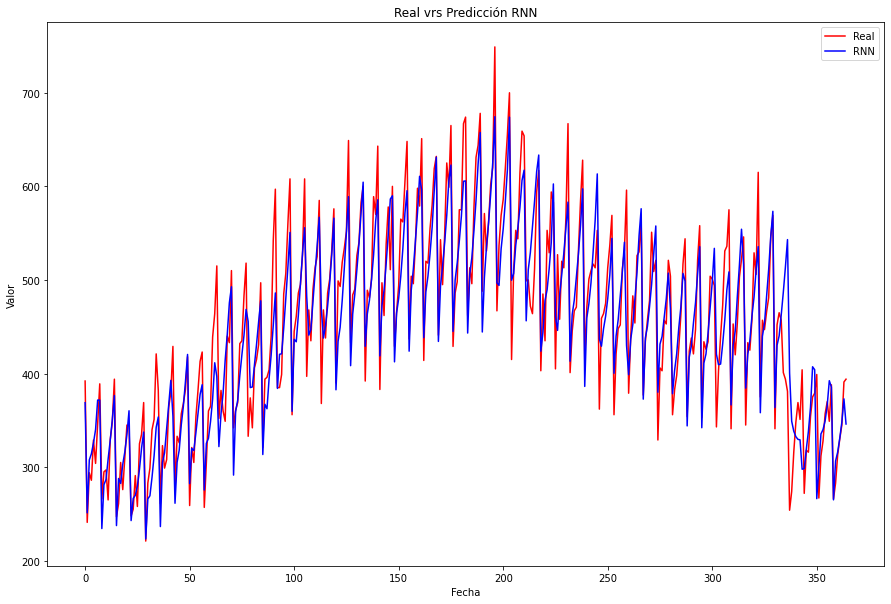

In [ ]:
plt.figure(figsize=(15, 10))
plt.plot(real_test_price, color="red", label="Real")
plt.plot(real_predicted_price, color="blue", label="RNN")
plt.title("Real vrs Predicción RNN")
plt.xlabel("Fecha")
plt.ylabel("Valor")
plt.legend()
plt.show()